In [3]:
import h5py
import glob
import os
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import cooler
import umap
import anndata
import harmonypy as hm
from itertools import cycle, islice

import igraph as ig
import leidenalg as la
from sklearn.neighbors import kneighbors_graph


import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import cooltools.lib.plotting

from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from statsmodels.sandbox.stats.multicomp import multipletests as FDR
from concurrent.futures import ProcessPoolExecutor, as_completed

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/projects/ps-renlab/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/projects/ps-renlab/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/projects/ps-renlab/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [4]:
# HiC basics metrices
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')

# import open2c libraries
import bioframe
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

## Visualize clustering results (Fig.4B)

In [39]:
### cell embedding and clustering is performed using higashi (https://github.com/ma-compbio/Higashi)
tmp = np.load("Higashi/embed/Higashi_embed.pkl", allow_pickle=True)

cell = pd.read_csv("230320/LC499_50_valid.bc_id.txt", sep = '\t', header = None)
cell['lib'] = cell[0].str.split(":").str[0]

umapp = umap.UMAP(n_neighbors=20, n_components=2, metric='cosine', local_connectivity=1.0, transform_seed=131)
yi = umapp.fit_transform(tmp)

### Run Leiden
data = pd.DataFrame(list(tmp))
knn_graph = kneighbors_graph(data, n_neighbors=15, mode='connectivity', include_self=False)
g = ig.Graph.Weighted_Adjacency(knn_graph.toarray().tolist())
g.vs['embedding'] = list(tmp)
partition = la.find_partition(g, la.RBConfigurationVertexPartition, resolution_parameter=0.8)
leiden_idt = [str(i) for i in partition.membership] 

In [41]:
c1 = ["#64a85c",
"#b75fb3",
"#b88f3e",
"#6785d0",
"#cb5658"]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 22 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'L', 'M', 'P', 'U', 'five', 'four', 'hyphen', 'minus', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 36, 38, 47, 48, 51, 56, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 22 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'L', 'M', 'P', 'U', 'five', 'four', 'hyphen', 'min

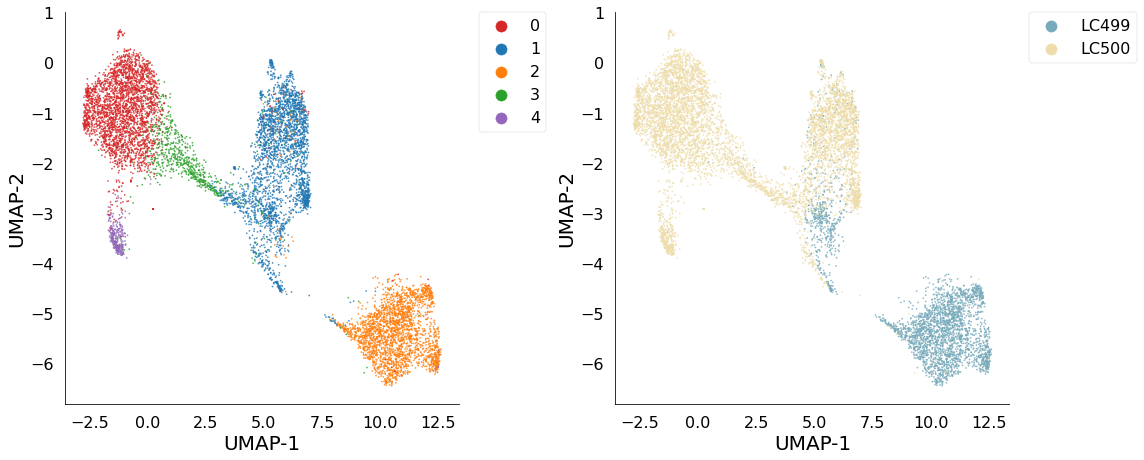

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6.5))

axes = ax[0]
sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=axes, s=3, alpha=0.8, linewidth=0, hue=leiden_idt)
handles, labels = axes.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axes.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
axes.set_xlabel('UMAP-1', fontsize=20)
axes.set_ylabel('UMAP-2', fontsize=20)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.tick_params(axis='both', which='both', length=0)

axes = ax[1]
sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=axes, s=3, alpha=0.8, linewidth=0, palette = "blend:#7AB,#EDA", hue = cell['lib'])
handles, labels = axes.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axes.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
axes.set_xlabel('UMAP-1', fontsize=20)
axes.set_ylabel('UMAP-2', fontsize=20)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.tick_params(axis='both', which='both', length=0)

plt.tight_layout()

plt.savefig("plot/GBM_230826_higashi_clustering.pdf")

## Visualize ecDNA by clusters (Fig.4E)

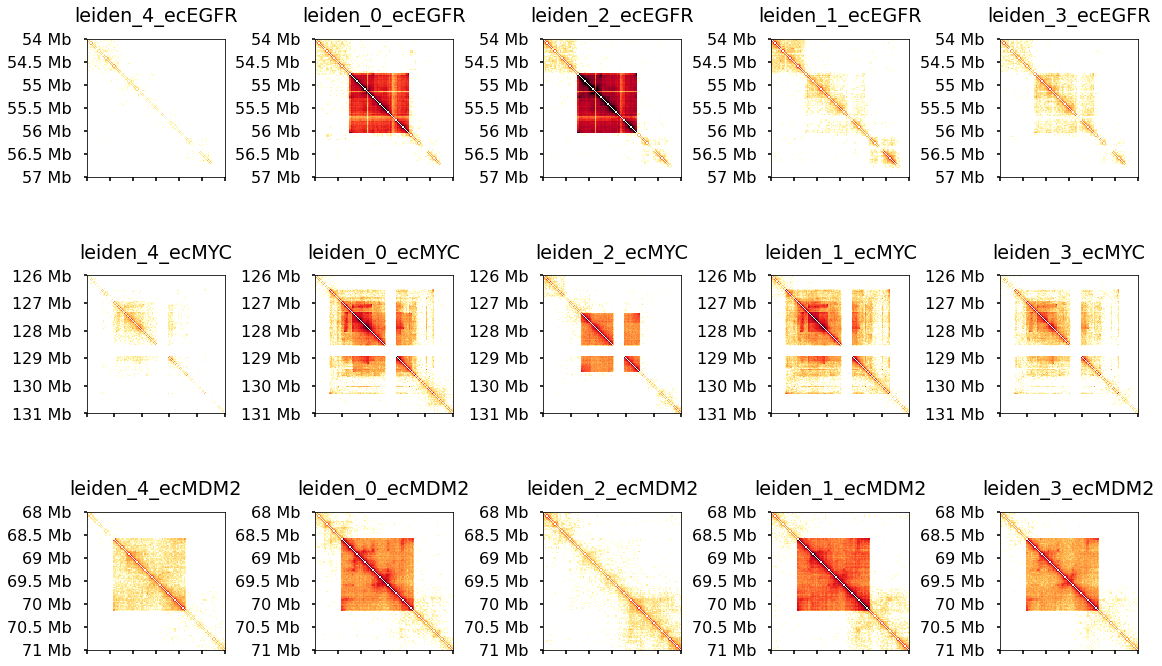

In [16]:
import re
files = os.listdir("../04.matrices/230320/higashi_cluster/")
sample = [re.sub('.mcool', '', file) for file in files if (file.startswith('leiden') & file.endswith('.mcool'))]

res = 25000
regions = [('chr7', 54_000_000, 57_000_000),
           ('chr8', 126_000_000, 131_000_000),
           ('chr12', 68_000_000, 71_000_000)]

names = ['ecEGFR', 'ecMYC', 'ecMDM2']

f, axes = plt.subplots(3, 5, figsize=(16, 10))
for idx, ct in enumerate(sample):
    for idy, rgn in enumerate(regions):
        clr = cooler.Cooler(f'../04.matrices/230320/higashi_cluster/{ct}.mcool::resolutions/{res}')
        Q = clr.matrix(balance=False).fetch(rgn)
        start = rgn[1]
        end = rgn[2]
        Q = Q - np.diag(np.diag(Q))
        vvmax = int(np.max(Q) / 10)
        ax = axes[idy, idx]
        im = ax.matshow(Q, cmap='fall', norm=LogNorm(vmax = 1000), extent = (start, end, end, start))
        format_ticks(ax)
        ax.set_xticklabels([])
        ax.set_title(f'{ct}_{names[idy]}', y  = 1.08)
        ax.xaxis.set_label_position('top')

plt.tight_layout()
# plt.savefig("plot/GBM_230826_LC499_500_genome_contact_map.pdf")

## Plor ecMYC local structure (Fig.4G)

In [13]:
### ec_count is from deep learning model based ecDNA finder
ec_count = pd.read_csv("GBM_231227_LC499_LC500_ecDNA_count_JC.xls", sep = '\t', index_col = 0)
ec_count['lib'] = ec_count.index.str.slice(0, 5)
ec_count.head()

,EGFR,MYC,MDM2,leiden,lib
LC499_AAACGAAAGAACAGGA,1,0,0,2,LC499
LC499_AAACGAACAAACGTTC,1,1,0,2,LC499
LC499_AAACGAACACAGGAAC,1,0,0,2,LC499
LC499_AAACGAAGTGCTTTGA,1,0,0,2,LC499
LC499_AAACGAAGTGGTTCTA,1,0,0,2,LC499


In [ ]:
### sample equal number of cells from both GBM39 and GBM39ER
lc499 = ec_count.loc[(ec_count['lib'] == 'LC499') & (ec_count['MYC'] == 1)]
lc500 = ec_count.loc[(ec_count['lib'] == 'LC500') & (ec_count['MYC'] == 1)]

chromp = 'chr8'
start, end = 126500000, 130500000
region = (chromp, start, end)

lc499_cvt = []
lc500_cvt = []
cell1 = 0
cell2 = 0
for idx in range(100): 
    ctv1t = lc499.index[idx]
    ctv2t = lc500.index[idx]
    try:
        c1 = cooler.Cooler(f'../04.matrices/230320/higashi_cluster/single_cell_contact/all_cluster/{ctv1t}/{ctv1t}.mcool::resolutions/25000')
        cell1 = cell1 + 1
        Q = c1.matrix(balance=False).fetch(region)
        Q = Q - np.diag(np.diag(Q))
        lc499_cvt.append(Q)
        
        c2 = cooler.Cooler(f'../04.matrices/230320/higashi_cluster/single_cell_contact/all_cluster/{ctv2t}/{ctv2t}.mcool::resolutions/25000')
        cell2 = cell2 + 1
        Q = c2.matrix(balance=False).fetch(region)
        Q = Q - np.diag(np.diag(Q))
        lc500_cvt.append(Q)
    except FileNotFoundError:
        print(ctv1t + " or " + ctv2t + " not found")
    except Exception as e:
        print(ctv1t + " or " + ctv2t + " not found")

print((cell1))
print((cell2))

### collapase
lc499_cvtn = np.sum(lc499_cvt, axis=0) / cell1
lc500_cvtn = np.sum(lc500_cvt, axis=0) / cell2

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 36 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'L', 'M', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 14, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 38, 47, 48, 60, 68, 70, 71, 72, 74, 79, 81, 82, 85, 86, 87, 88, 89, 90, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 36 g

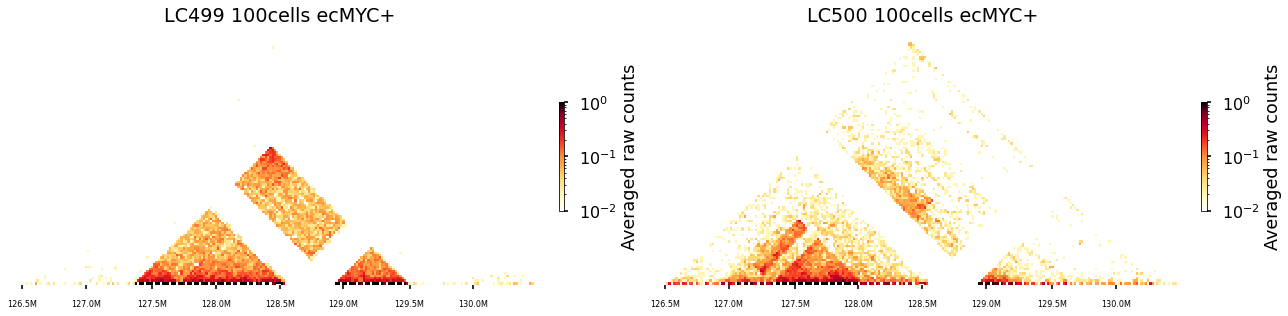

In [41]:
f, axes = plt.subplots(1, 2, figsize=(18, 9))
res = 25000
for idx in range(2):
    mtx = [lc499_cvtn, lc500_cvtn][idx]
    name = ["LC499", "LC500"][idx]
    ax = axes[idx]
    Qrotate = nd.rotate(mtx, 45, order=0, reshape=True, prefilter=False, cval=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    im = ax.matshow(Qrotate, cmap='fall', norm=LogNorm(vmax = 1))
    h = len(Qrotate)
    ax.set_ylim([0.5*h, 0])
    ax.set_xlim([0, h])
    ax.set_yticks([])
    ax.set_yticklabels([])

    pos_list_new = range(0, int((end - start)/25000), 20)
    new_pos_list = [round(np.sqrt(2)*ii) for ii in pos_list_new]
    ax.set_xticks(new_pos_list)
    ax.set_xticklabels([str(126.5 + (i/40)) + "M" for i in pos_list_new], fontsize = 8)

    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(f'{name} 100cells ecMYC+')
    plt.colorbar(im, ax=ax, fraction=0.01, pad=0.04, label='Averaged raw counts')

plt.tight_layout()
plt.savefig(f"plot/GBM39_LC499_LC500_ecMYC_100cells_average_{chromp}_{start}_{end}_res{res}.pdf")